**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/aloiswirth/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting classifiers

The following random.rand prozess creates 10 series of 10000 random coin tosses, in a way that 51% end up as head and 49% as tail

In [0]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Here now using pandas to describe the data set

In [6]:
print(coin_tosses)
import pandas as pd
pd_coin_tosses = pd.DataFrame(coin_tosses)
print(pd_coin_tosses.describe())
print(pd_coin_tosses.head(3))
print(pd_coin_tosses.tail(3))

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 1]
 [0 1 1 ... 0 0 1]
 ...
 [1 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 1]
 [0 1 0 ... 0 1 1]]
                  0             1  ...             8             9
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean       0.511300      0.511500  ...      0.510800      0.510200
std        0.499897      0.499893  ...      0.499908      0.499921
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        1.000000      1.000000  ...      1.000000      1.000000
75%        1.000000      1.000000  ...      1.000000      1.000000
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 10 columns]
   0  1  2  3  4  5  6  7  8  9
0  1  0  0  0  1  1  1  0  0  0
1  1  0  0  1  1  1  1  0  1  1
2  0  1  1  1  1  0  1  0  0  1
      0  1  2  3  4  5  6  7  8  9
9997  1  1  0  0  1  0  0  1  1  0
9998  0  0  1  1  0  1  0  1  1  1
9999  0  1  0  1  0  

Saving figure law_of_large_numbers_plot


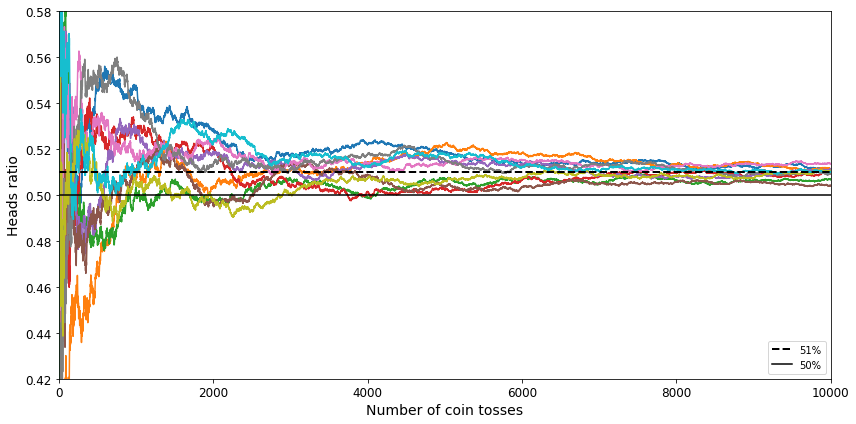

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [13]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting:

In [16]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [17]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging ensembles

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


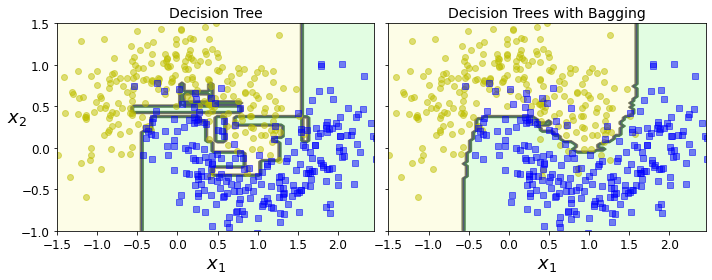

In [22]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

In [24]:
new_bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True
)
new_bag_clf.fit(X_train, y_train)
print(new_bag_clf.oob_score_)


0.896


In [26]:
from sklearn.metrics import accuracy_score
y_pred_train = new_bag_clf.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

y_pred_test = new_bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_test))

1.0
0.912


# Random Forests

In [0]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [0]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [30]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

In [31]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [32]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

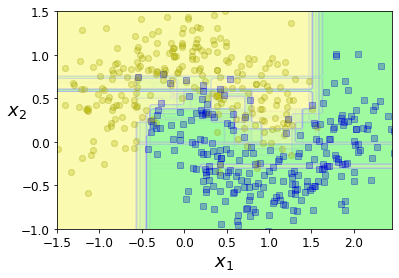

In [33]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

In [0]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [0]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [34]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

## Feature importance

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


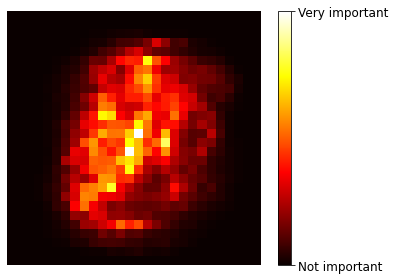

In [38]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

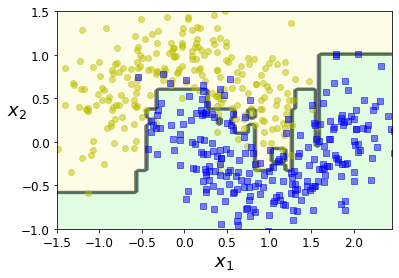

In [40]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


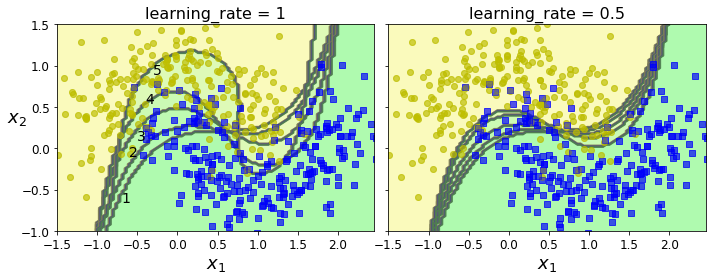

In [41]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [42]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

list(m for m in dir(ada_clf))![alt text](https://)

In [43]:
list(m for m in dir(ada_clf))

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_boost',
 '_boost_discrete',
 '_boost_real',
 '_compute_proba_from_decision',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_required_parameters',
 '_validate_data',
 '_validate_estimator',
 'algorithm',
 'base_estimator',
 'base_estimator_',
 'classes_',
 'decision_function',
 'estimator_errors_',
 'estimator_params',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'fit',
 

# Gradient Boosting

In [0]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [0]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [0]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [0]:
X_new = np.array([[0.8]])

In [0]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [0]:
y_pred

array([0.75026781])

In [0]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


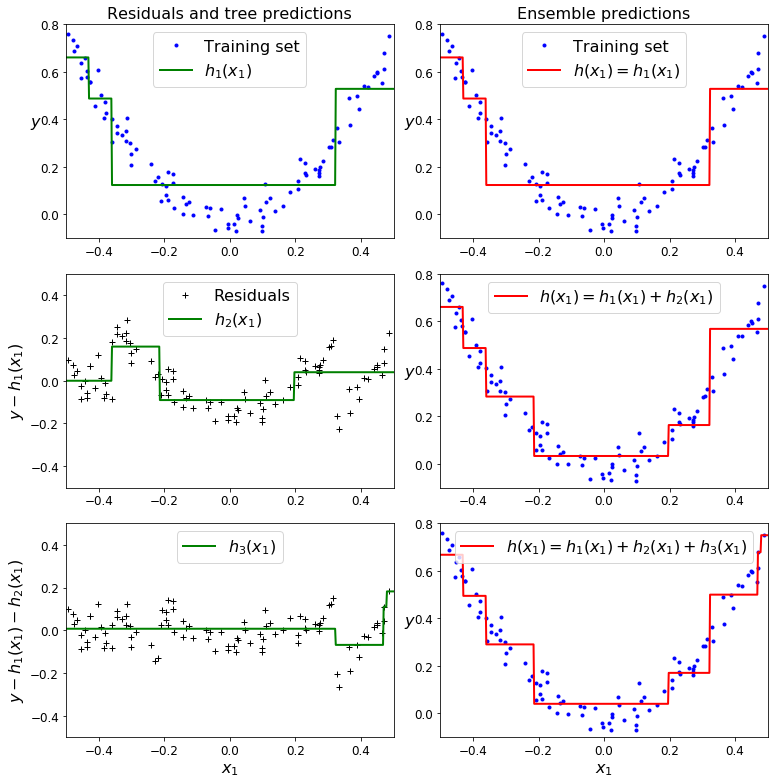

In [0]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


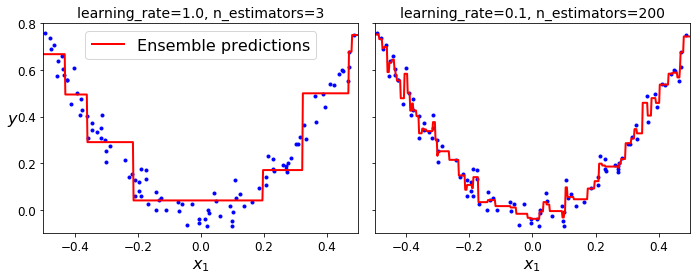

In [0]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=56, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


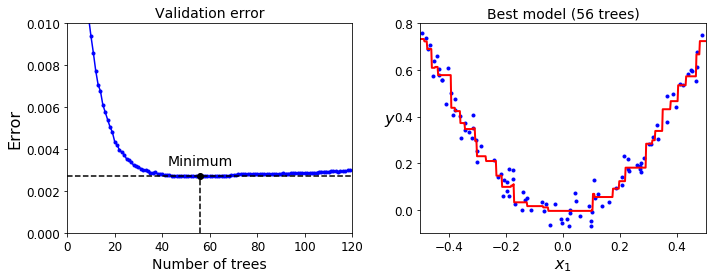

In [0]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [0]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [0]:
print(gbrt.n_estimators)

61


In [0]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## Using XGBoost

In [0]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [0]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [0]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[

In [0]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [0]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

12.9 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [0]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [0]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_clas

/Users/ageron/miniconda3/envs/tf2b/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [0]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8641, 0.9603]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [0]:
from sklearn.ensemble import VotingClassifier

In [0]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [0]:
voting_clf = VotingClassifier(named_estimators)

In [0]:
voting_clf.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/tf2b/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [0]:
voting_clf.score(X_val, y_val)

0.9704

In [0]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8641, 0.9603]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [0]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

This updated the list of estimators:

In [0]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,

However, it did not update the list of _trained_ estimators:

In [0]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2',

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [0]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [0]:
voting_clf.score(X_val, y_val)

0.9732

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [0]:
voting_clf.voting = "soft"

In [0]:
voting_clf.score(X_val, y_val)

0.9672

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [0]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9704

In [0]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9602]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [0]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [0]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [0]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [0]:
rnd_forest_blender.oob_score_

0.9696

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [0]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [0]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(y_test, y_pred)

0.9669

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.